# TimeSeries Project (e-commerce dataset)

Problems encountered in dataset:
- Columns separated with character (')
- Float separated with comma 
- Totale column with negative values

In [109]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

## Import dataset and formatting types

In [2]:
df = pd.read_csv('.\data\serie-storiche-ecommerce.csv', quotechar="'", parse_dates=["data"])
df["totale"] = df["totale"].apply(lambda x : (x.replace(",", ".")))
df["totale"] = df["totale"].astype(float)
df.sort_values('data', inplace=True)
df.head()

,data,totale,settore
0,2013-02-01,815.97,Calcio
1,2013-02-21,4775.75,Fitness
2,2013-04-01,4775.75,Fitness
3,2013-04-06,1962.15,Casual
4,2013-07-09,1809.87,Basket


In [3]:
### descriptive analysis on total column
df["totale"].describe()

count     25261.000000
mean       7886.239314
std       13273.856514
min       -2159.180000
25%        1335.300000
50%        3948.860000
75%       10209.730000
max      516104.930000
Name: totale, dtype: float64

In [4]:
df.isnull().sum()

data       0
totale     0
settore    0
dtype: int64

In [5]:
df = df[df["totale"]>0]

### Data exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25227 entries, 0 to 25260
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     25227 non-null  datetime64[ns]
 1   totale   25227 non-null  float64       
 2   settore  25227 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 788.3+ KB


In [7]:
### descriptive analysis on total column
df["totale"].describe()

count     25227.000000
mean       7896.953680
std       13279.580998
min           0.270000
25%        1337.210000
50%        3966.870000
75%       10224.470000
max      516104.930000
Name: totale, dtype: float64

In [8]:
### Check for missing days
from datetime import timedelta

### Group by per data to sum total earnings
df_sells_day = pd.DataFrame(df.groupby(by="data", sort=True, as_index=False)["totale"].sum())

list_missing_dates = []
previous_date = df_sells_day['data'][0] - timedelta(days=1)
for date in df_sells_day['data']:
    if date-timedelta(days=1) != previous_date:
        list_missing_dates.append(date)
    previous_date = date

print('Last date with missing previous day: ' + str(list_missing_dates[-1]))

Last date with missing previous day: 2014-02-20 00:00:00


In [9]:
### Keep only days after the 2014-02-20 and discard the last day too (very low value, could be partial data, maybe extracted not at the end of the day)
df_sells_day = df_sells_day[(df_sells_day['data'] > '2014-02-20') & (df_sells_day['data'] < '2022-04-01')]

(15862.0, 19357.0)

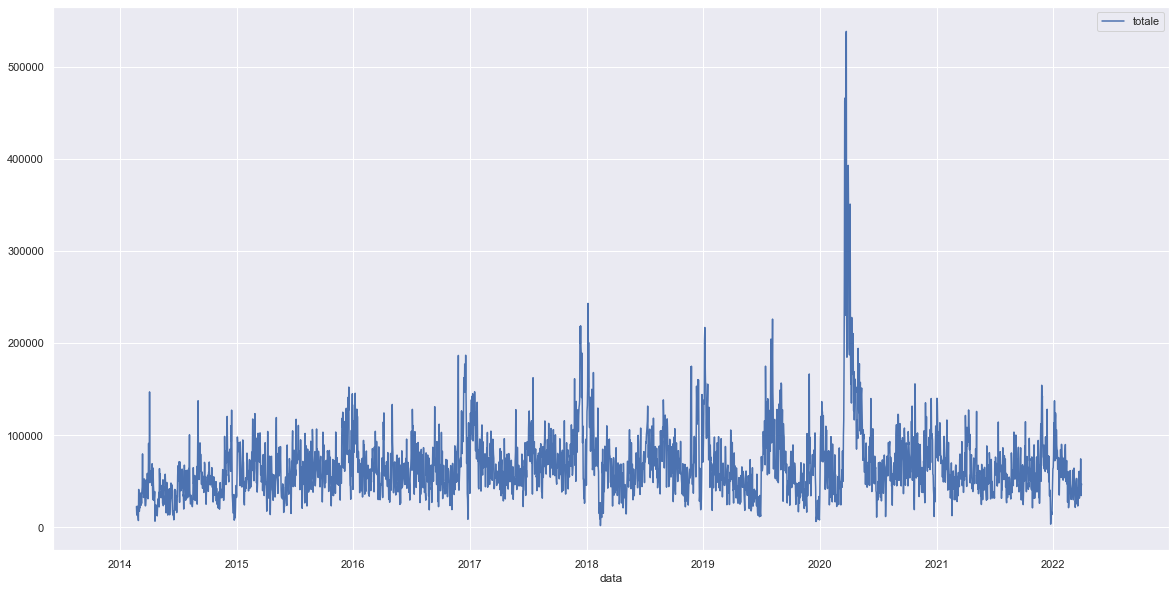

In [10]:
### Plot daily sells
fig, ax = plt.subplots(figsize=(20,10))
df_sells_day.plot(x='data', y='totale', ax=ax)
plt.xlim(left='2013-06-06', right='2022-12-31')

Text(1.0, 1.0, 'Sells per month')

<Figure size 1440x720 with 0 Axes>

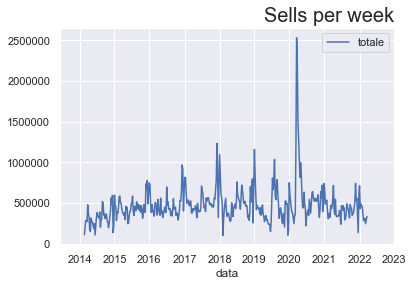

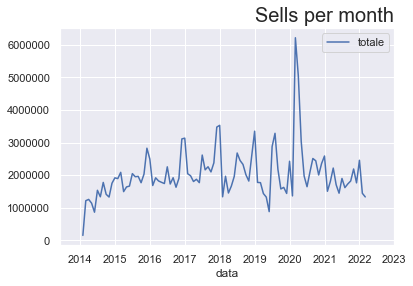

In [11]:
### Group by per data to sum total earnings (1 week and 1 month timeslice)
plt.figure(figsize=(20,10))

# 1 week sum
df_sells_week = pd.DataFrame(df_sells_day.groupby(pd.Grouper(key='data', freq='7d'))['totale'].sum()).reset_index('data')
df_sells_week.plot(x='data', y='totale')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(left='2013-06-06', right='2023-01-01')
plt.title('Sells per week', loc='right', fontdict={'fontsize': 20})

# 1 month sum
df_sells_month = pd.DataFrame(df_sells_day.groupby(pd.Grouper(key='data', freq='1m'))['totale'].sum()).reset_index('data')
df_sells_month.plot(x='data', y='totale')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(left='2013-06-06', right='2023-01-01')
plt.title('Sells per month', loc='right', fontdict={'fontsize': 20})

In [12]:
### Pivot by month
df_sells_day['anno'] = [d.year for d in df_sells_day['data']]
df_sells_day['mese'] = [d.month for d in df_sells_day['data']]

df_mese = pd.DataFrame(df_sells_day.groupby(by=['anno', 'mese'])['totale'].sum()).reset_index()
df_mese = df_mese.pivot(index="mese", columns="anno", values="totale")
df_mese.describe()

anno,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,1.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,3.000000e+00
mean,1.249578e+06,1.938444e+06,1.997196e+06,2.298046e+06,2.147691e+06,1.957926e+06,2.758411e+06,1.855226e+06,1.742187e+06
std,4.496960e+05,3.339884e+05,4.291439e+05,5.327952e+05,6.092255e+05,7.983349e+05,1.431321e+06,3.273135e+05,6.193382e+05
min,1.488231e+05,1.492607e+06,1.627219e+06,1.768157e+06,1.334476e+06,8.785999e+05,1.361682e+06,1.444479e+06,1.330307e+06
25%,1.175879e+06,1.740015e+06,1.737415e+06,1.952222e+06,1.778270e+06,1.436306e+06,1.995257e+06,1.681110e+06,1.386064e+06
50%,1.325950e+06,1.932309e+06,1.860432e+06,2.129405e+06,1.988325e+06,1.695611e+06,2.389943e+06,1.781493e+06,1.441821e+06
75%,1.472324e+06,2.034131e+06,2.002596e+06,2.436196e+06,2.483887e+06,2.350911e+06,2.641094e+06,1.969583e+06,1.948127e+06
max,1.774890e+06,2.825318e+06,3.109826e+06,3.473589e+06,3.526956e+06,3.347046e+06,6.214672e+06,2.585867e+06,2.454433e+06


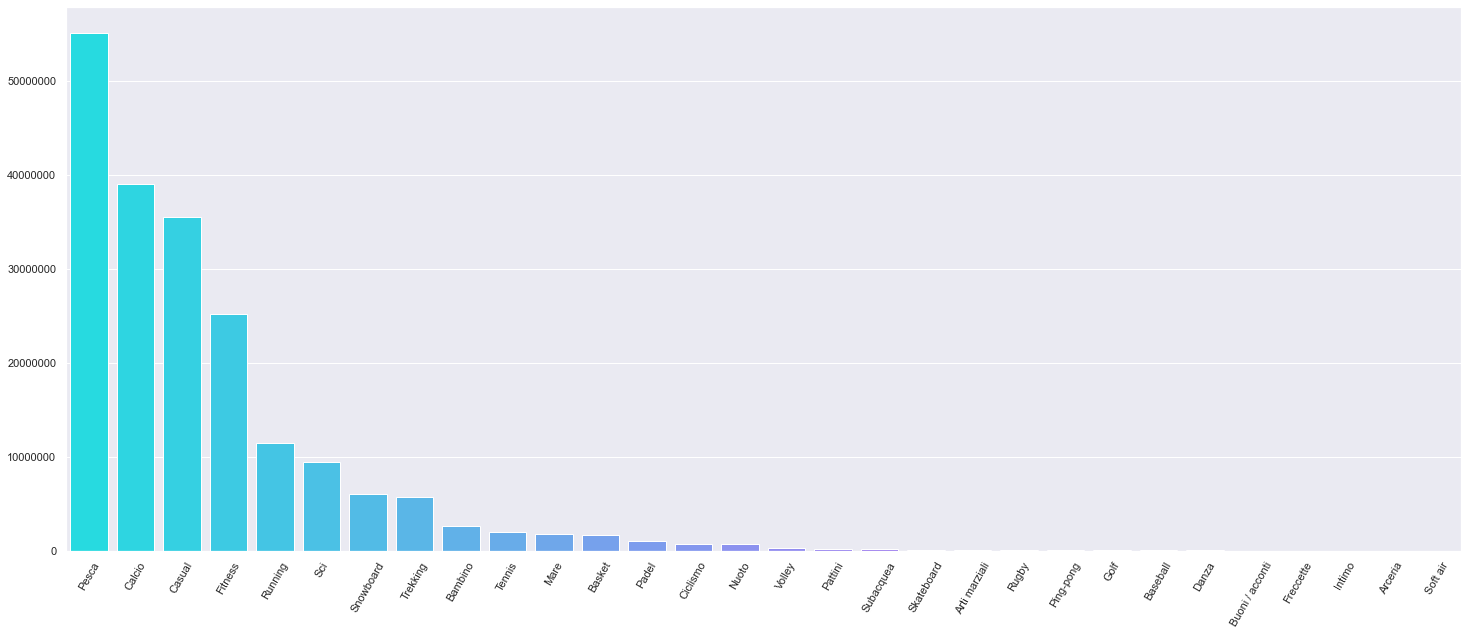

In [13]:
### Group by per category and sum up
df_groupby_settore = df.groupby(by=["settore"], sort=True)["totale"].sum().sort_values(ascending=False)
plt.figure(figsize=(25,10))
plt.xticks(rotation=60)
sns.barplot(x=list(df_groupby_settore.index), y=list(df_groupby_settore.values), palette="cool")
plt.ticklabel_format(style='plain', axis='y')


<AxesSubplot:xlabel='data'>

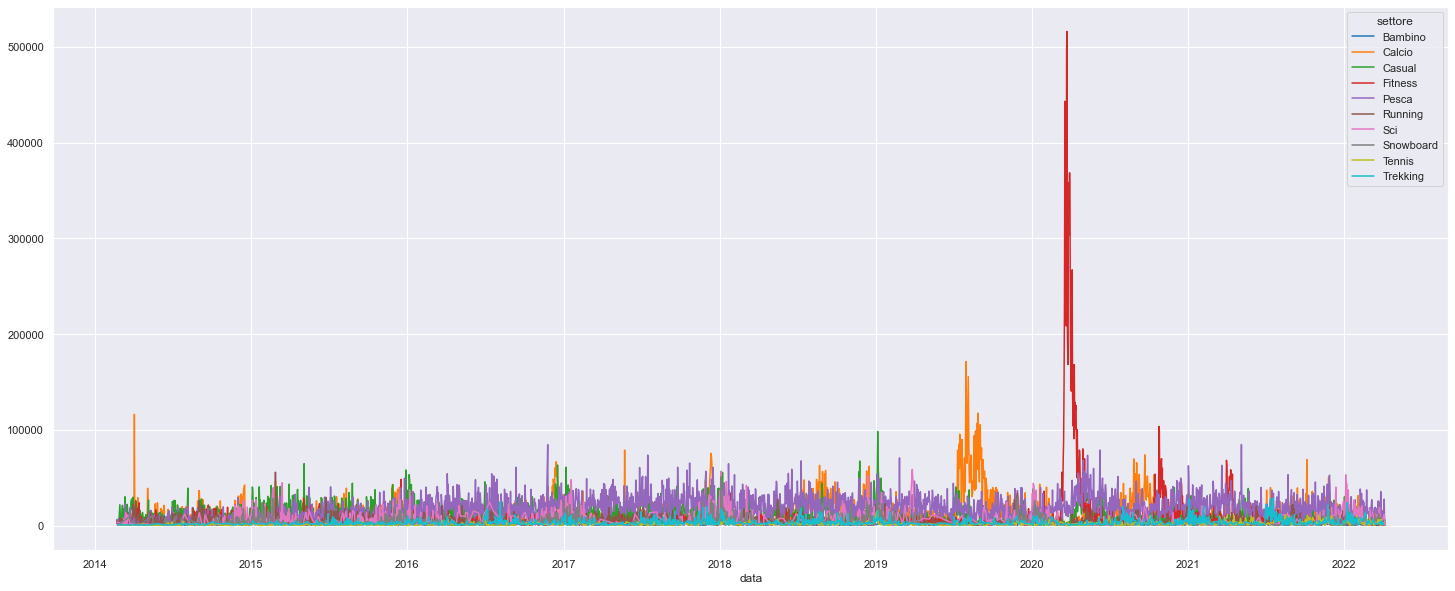

In [14]:
### time series group by higher sectors in total 
list_high_number_total = df_groupby_settore.index[0:10]
df_pivot_settore_and_data = (df[(df['data'] > '2014-02-20') & (df['data'] < '2022-04-08')].query("settore in @list_high_number_total")).pivot(index="data", columns="settore", values="totale")
plt.figure(figsize=(25,10))
sns.lineplot(data=df_pivot_settore_and_data, dashes=False, palette="tab10")

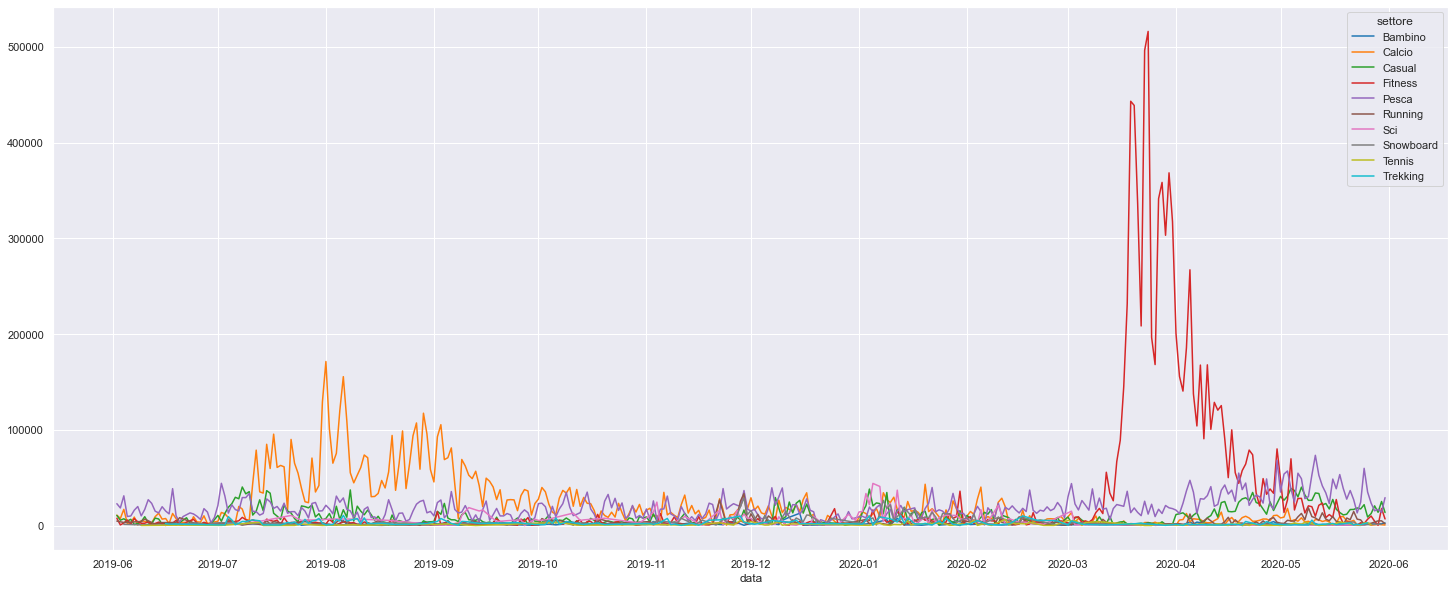

In [49]:
plt.figure(figsize=(25,10))
ax = sns.lineplot(data=df_pivot_settore_and_data[(df_pivot_settore_and_data.index > '2019-06-01') & (df_pivot_settore_and_data.index < '2020-06-01')], dashes=False, palette="tab10")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

In [15]:
df_pivot_settore_and_data.describe()

settore,Bambino,Calcio,Casual,Fitness,Pesca,Running,Sci,Snowboard,Tennis,Trekking
count,1249.000000,2925.000000,2873.000000,2814.000000,2948.000000,2220.000000,1196.000000,1366.000000,972.000000,1514.000000
mean,2084.029736,13309.391921,12305.651730,8930.101446,18643.251957,5126.232239,7872.570886,4355.605007,2039.352294,3764.138137
std,2173.208435,13945.831456,9170.503593,28033.950556,11502.796926,4260.194013,8419.277251,4994.947934,2054.405058,3661.227758
min,81.870000,106.430000,162.100000,45.440000,36.840000,0.270000,2.730000,95.520000,36.840000,121.440000
25%,762.210000,5262.600000,5730.900000,2372.595000,10244.667500,2292.292500,1756.252500,1135.260000,614.030000,1335.300000
50%,1361.770000,9493.650000,10315.620000,4356.575000,16990.345000,3929.760000,5387.050000,2464.970000,1397.930000,2524.870000
75%,2677.150000,16000.400000,16511.810000,7788.430000,25198.020000,6871.755000,10902.360000,5645.072500,2863.402500,4947.202500
max,25858.090000,171365.370000,98255.460000,516104.930000,84700.250000,55733.000000,58780.480000,50980.720000,15268.760000,28574.540000


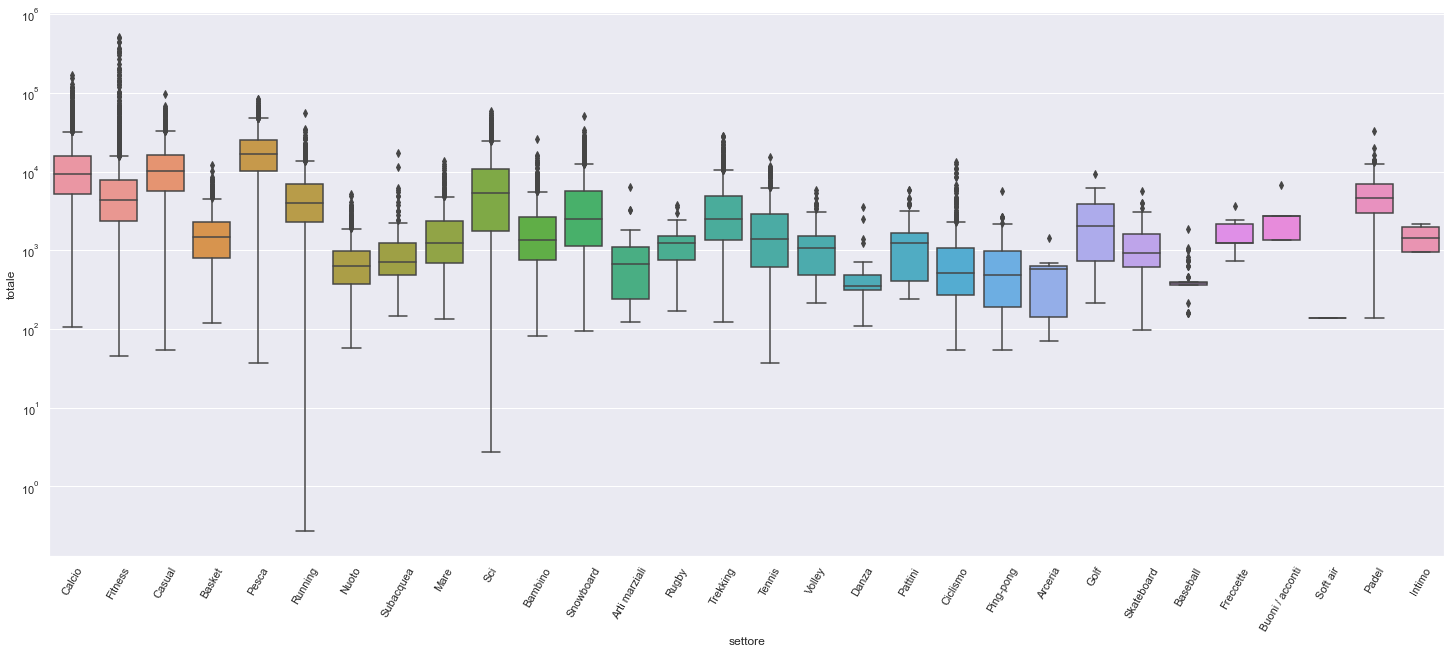

In [16]:
### boxplot to see correlation between cost spent and category
plt.figure(figsize=(25,10))
plt.xticks(rotation=60)
plot = sns.boxplot(data=df, x="settore", y="totale")
plot.set_yscale("log")

## Time series decomposition

### Decompose daily

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

In [18]:
df_sells_day_decomp = df_sells_day[(df_sells_day['data'] > '2014-02-20')]
df_sells_day_decomp = df_sells_day_decomp.set_index('data')
df_sells_day_decomp['boxcox'], lam = boxcox(df_sells_day_decomp['totale'])

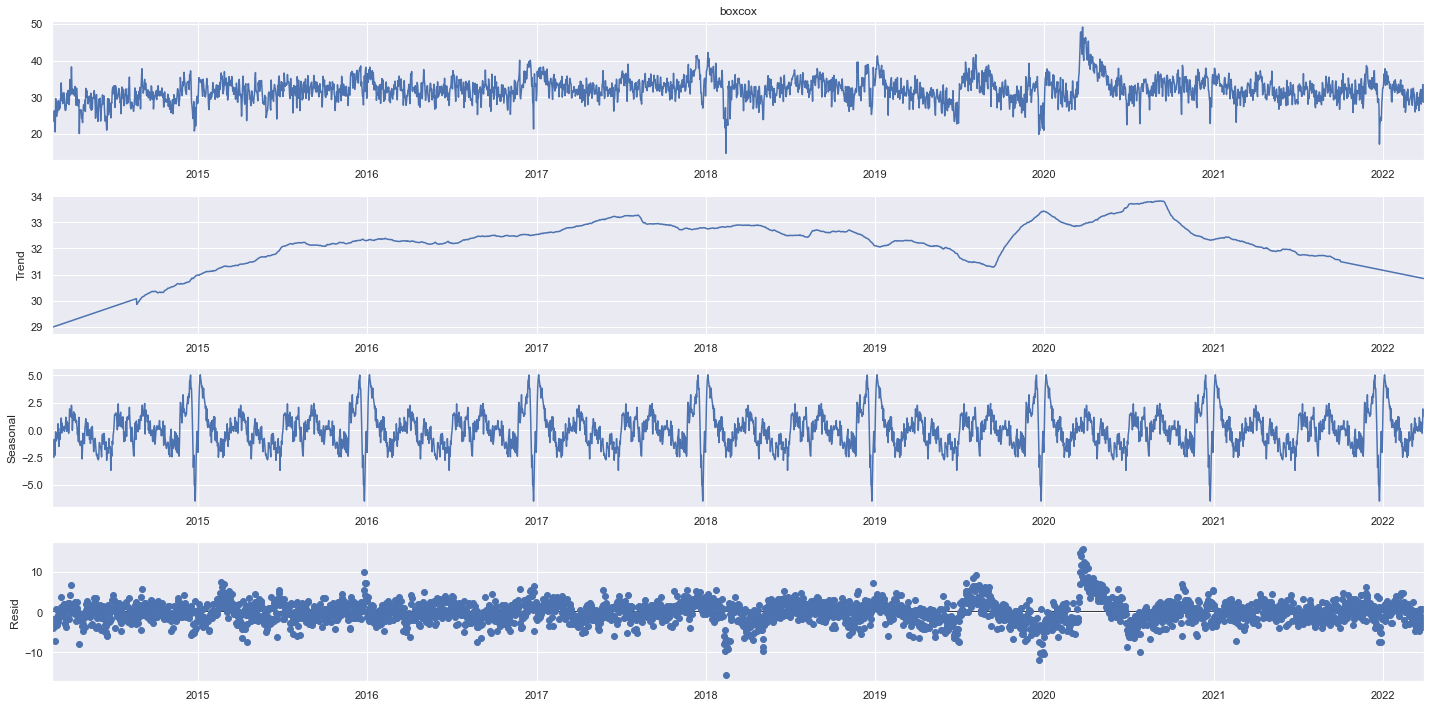

In [19]:
decompose_day = seasonal_decompose(df_sells_day_decomp['boxcox'], model='add', period=365, extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (20,10)})
decompose_day.plot()
plt.show()

### Decompose weekly

In [20]:
df_sells_week['boxcox'], lam = boxcox(df_sells_week['totale'])
df_sells_week.set_index('data', inplace=True)

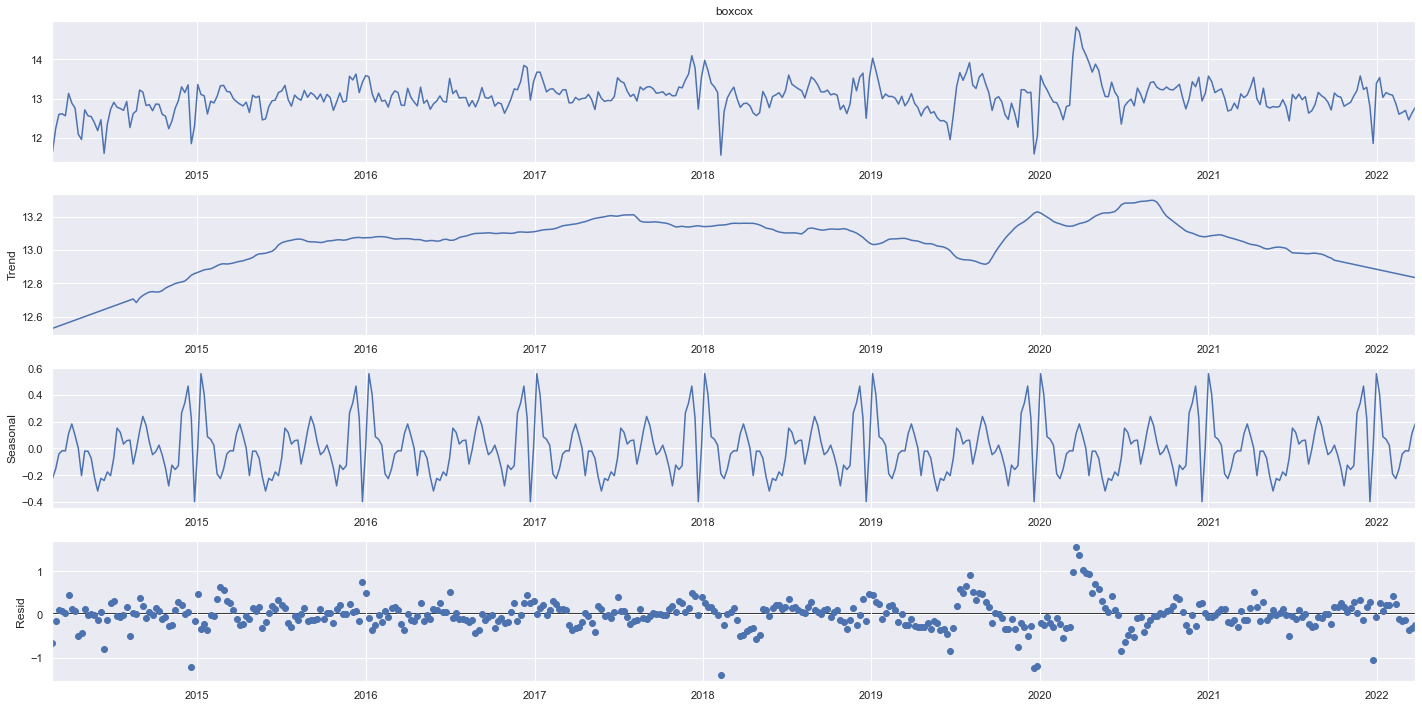

In [21]:
decompose_week = seasonal_decompose(df_sells_week['boxcox'], model='add', period=52, extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (20,10)})
decompose_week.plot()
plt.show()

### Decompose monthly

In [22]:
df_sells_month['boxcox'], lam = boxcox(df_sells_month['totale'])
df_sells_month.set_index('data', inplace=True)

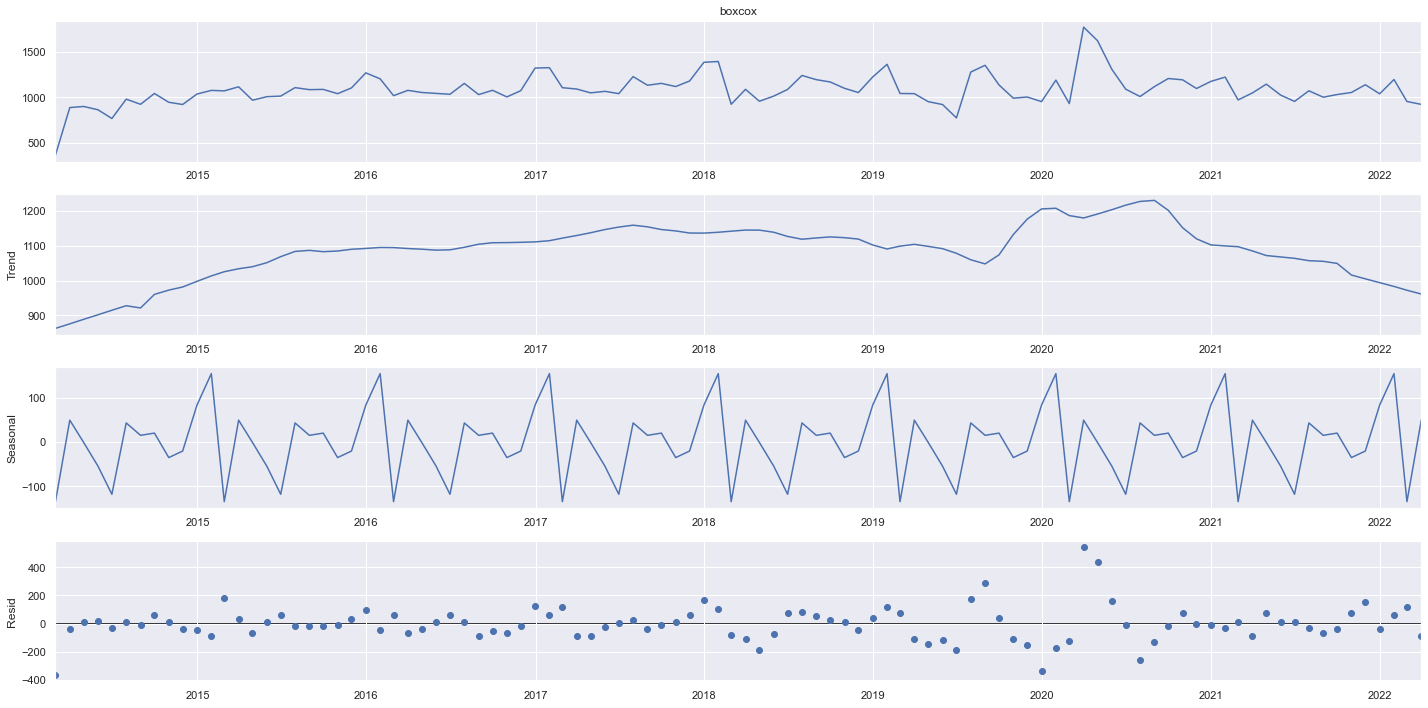

In [23]:
decompose_year = seasonal_decompose(df_sells_month['boxcox'], model='add', period=12, extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (20,10)})
decompose_year.plot()
plt.show()

## Time series analysis

### Model selection

#### FbProphet

In [62]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


In [93]:
df_fb = df_sells_week.reset_index().copy()
df_fb.drop(['boxcox'], axis=1, inplace=True)
df_fb.columns = ['ds', 'y']

In [119]:
%%capture
param_grid = {  
    'changepoint_prior_scale': [0.05, 0.5, 1, 5, 10, 20, 30],
    'seasonality_prior_scale': [0.05, 0.5, 1, 5, 10, 20, 30],
    'seasonality_mode': ['multiplicative', 'additive']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_fb[df_fb['ds'] < '2020-03-01'])  # Fit model with given params
    df_cv = cross_validation(m, initial='1460 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2018-03-05 00:00:00 and 2019-02-28 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2018-03-05 00:00:00 and 2019-02-28 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2018-03-05 00:00:00 and 2019-02-28 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to ov

In [136]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results.iloc[np.argmin(mape)])

changepoint_prior_scale               1.0
seasonality_prior_scale               1.0
seasonality_mode           multiplicative
mape                             0.364617
Name: 32, dtype: object


In [141]:
df_fb_train = df_fb[df_fb['ds'] < '2018-06-01']
df_fb_test = df_fb[(df_fb['ds'] >='2018-06-01') & (df_fb['ds'] < '2020-03-01')]

In [142]:
model = Prophet(changepoint_prior_scale=1.0, seasonality_prior_scale=1.0, seasonality_mode='multiplicative')
model.fit(df_fb_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [143]:
forecast = model.predict(df_fb_test)

c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


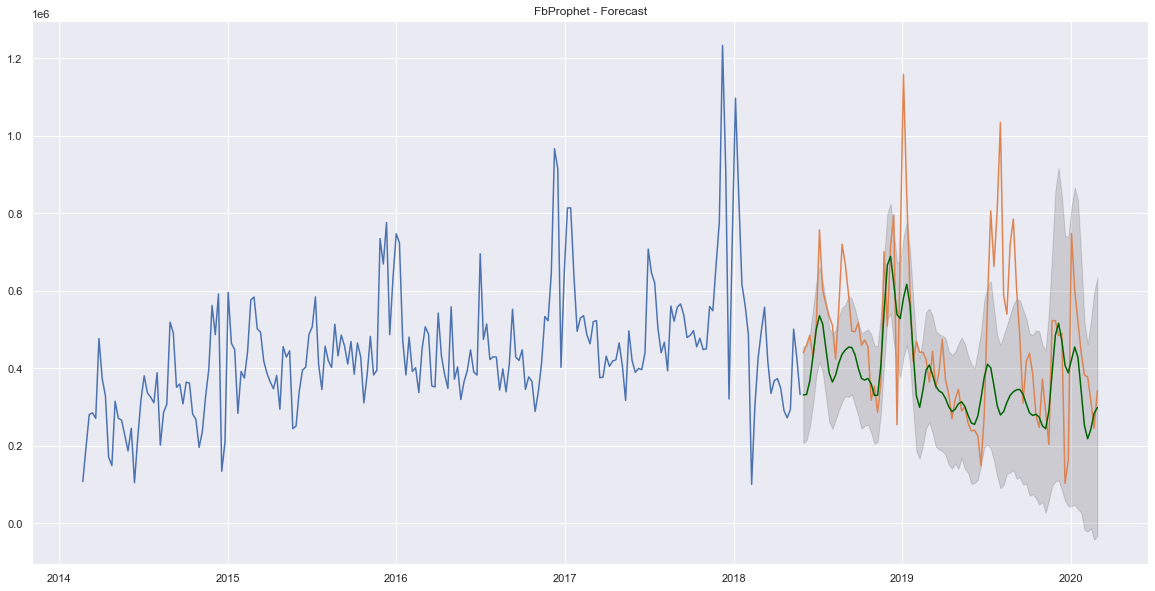

In [144]:
# Plot
plt.plot(df_fb_train.set_index('ds')['y'])
plt.plot(df_fb_test.set_index('ds')['y'])
plt.plot(forecast.set_index('ds')['yhat'], color='darkgreen')
plt.fill_between(forecast.set_index('ds').index, 
                 forecast.set_index('ds')['yhat_lower'], 
                 forecast.set_index('ds')['yhat_upper'], 
                 color='k', alpha=.15)

plt.title("FbProphet - Forecast")
plt.show()

In [160]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)       # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [161]:
forecast_accuracy(np.array(forecast['yhat']), np.array(df_fb_test['y']))

{'mape': 0.2872809948263151,
 'me': -92145.63556627734,
 'mae': 131378.51861910312,
 'mpe': -0.08474401982951706,
 'mse': 34772595601.94789,
 'rmse': 186474.11509898066,
 'corr': 0.5193174913019681,
 'minmax': 0.23636802021562886}

#### SARIMA

In [24]:
import pmdarima as pm

In [25]:
df_sells_month_train = df_sells_month[df_sells_month.index < '2019-01-01']
df_sells_month_test = df_sells_month[(df_sells_month.index > '2018-12-30') & (df_sells_month.index < '2021-12-31')]

In [152]:
smodel = pm.auto_arima(df_fb_train['y'], start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=52,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=4442.877, Time=3.76 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=4516.858, Time=0.36 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=4478.351, Time=1.76 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=4449.891, Time=2.77 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=4463.138, Time=0.79 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=4444.854, Time=4.68 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=4444.843, Time=11.84 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=4445.069, Time=4.01 sec
 ARIMA(1,1,1)(1,1,2)[52]             : AIC=4446.463, Time=30.49 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=4473.115, Time=3.12 sec
 ARIMA(2,1,1)(0,1,1)[52]             : AIC=4439.143, Time=4.50 sec
 ARIMA(2,1,1)(0,1,0)[52]             : AIC=4462.817, Time=1.21 sec
 ARIMA(2,1,1)(1,1,1)[52]             : AIC=4441.113, Time=8.21 sec
 ARIMA(2,1,1)(0,1,2)[52]             : AIC=4441.105, Time=15.50 sec
 ARIMA(2,1,1)(1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  223
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -2211.266
Date:                            Mon, 16 May 2022   AIC                           4436.532
Time:                                    16:57:26   BIC                           4458.482
Sample:                                         0   HQIC                          4445.439
                                            - 223                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4903      0.086      5.715      0.000       0.322       0.658
ar.L2         -0.0766      0.131     -0.587      0.557      -0.333       0.179
ar.L3          0.1093      0.124      0.882      0.378      -0.134       0.352
ar.L4          0.2314      0.090      2.567      0.010       0.055       0.408
ma.L1         -0.9582      0.064    -14.917      0.000      -1.084      -0.832
ma.S.L52      -0.4207      0.091     -4.601      0.000      -0.600      -0.242
sigma2      1.323e+10   1.98e-12   6.69e+21      0.000    1.32e+10    1.32e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                38.36
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.26
Prob(H) (two-sided):                  0.43   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.53e+37. Standard errors may be unstable.
"""

In [154]:
# Forecast
n_periods = 92
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)

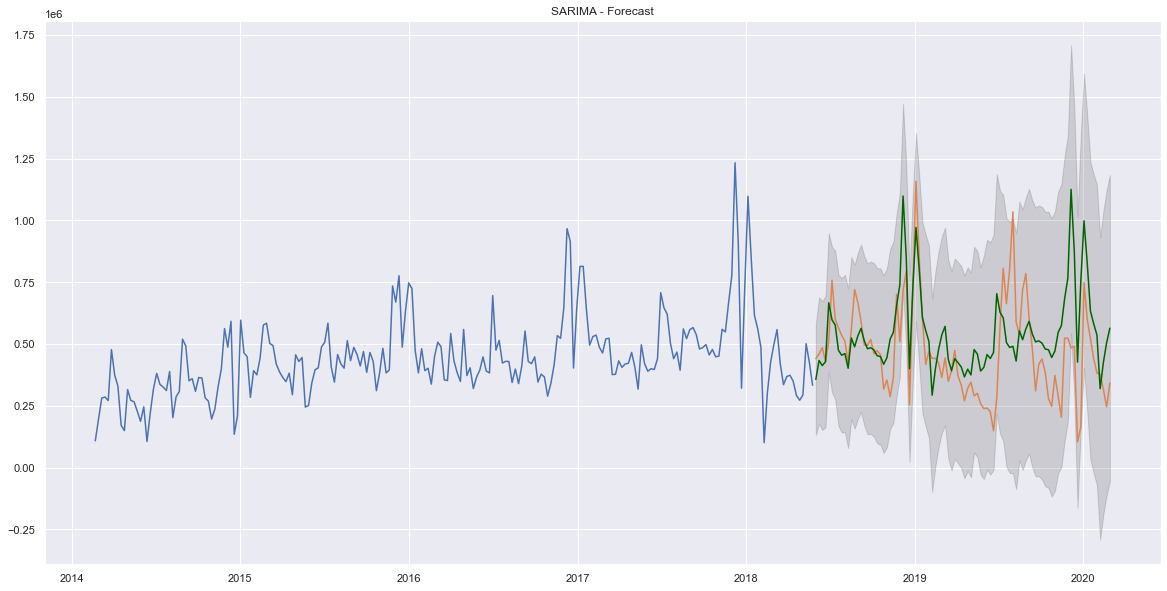

In [155]:
# Plot

# make series for plotting purpose
index_of_fc = list(df_fb_test['ds'])
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


plt.plot(df_fb_train.set_index('ds')['y'])
plt.plot(df_fb_test.set_index('ds')['y'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Forecast")
plt.show()

In [162]:
forecast_accuracy(np.array(fitted), np.array(df_fb_test['y']))

{'mape': 0.42181896225228316,
 'me': 69660.35982304324,
 'mae': 145735.05380953714,
 'mpe': 0.31076999619451984,
 'mse': 37623455425.73706,
 'rmse': 193967.6659284662,
 'corr': 0.47054565566457746,
 'minmax': 0.24264424169034904}

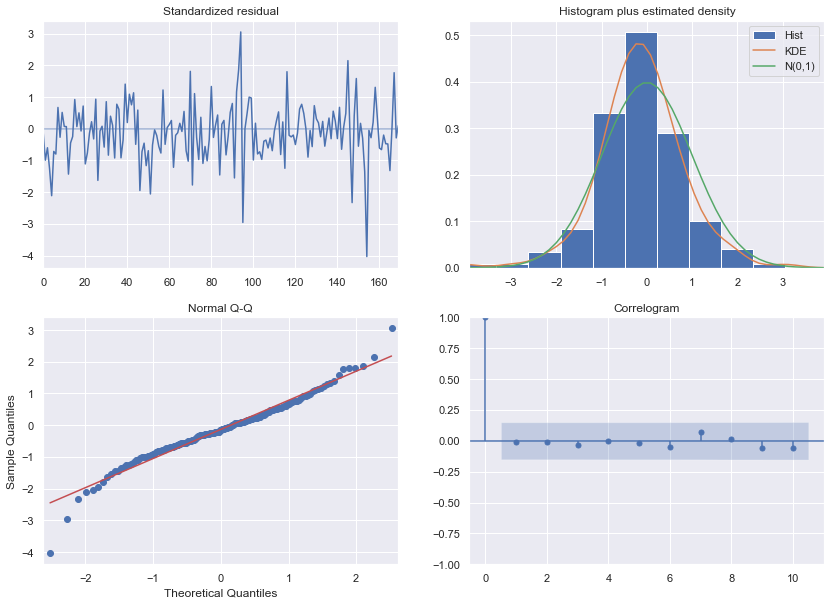

In [163]:
smodel.plot_diagnostics(figsize=(14,10))
plt.show()

### Test with FbProphet

In [30]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [31]:
df_fb = df_sells_day.copy()
df_fb.drop(['anno', 'mese'], axis=1, inplace=True)
df_fb.columns = ['ds', 'y']

In [32]:
df_fb_train = df_fb[df_fb['ds'] < '2020-01-01']
df_fb_test = df_fb[(df_fb['ds'] > '2020-01-01') & (df_fb['ds'] < '2022-01-01')]

In [33]:
model = Prophet()
model.fit(df_fb_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [34]:
forecast = model.predict(df_fb_test)

c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


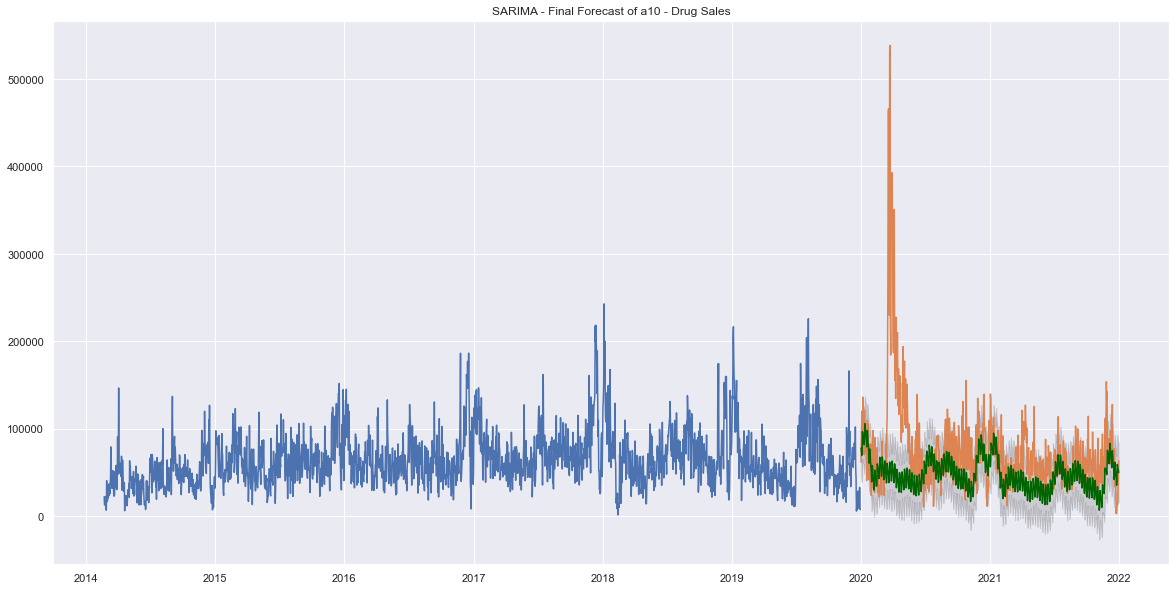

In [35]:
# Plot
plt.plot(df_fb_train.set_index('ds')['y'])
plt.plot(df_fb_test.set_index('ds')['y'])
plt.plot(forecast.set_index('ds')['yhat'], color='darkgreen')
plt.fill_between(forecast.set_index('ds').index, 
                 forecast.set_index('ds')['yhat_lower'], 
                 forecast.set_index('ds')['yhat_upper'], 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

In [36]:
model = Prophet()
model.fit(df_fb)

future_dates = pd.date_range(list(df_fb['ds'])[-1], periods = 365, freq='D')
df_future = pd.DataFrame()
df_future['ds'] = future_dates
forecast = model.predict(df_future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


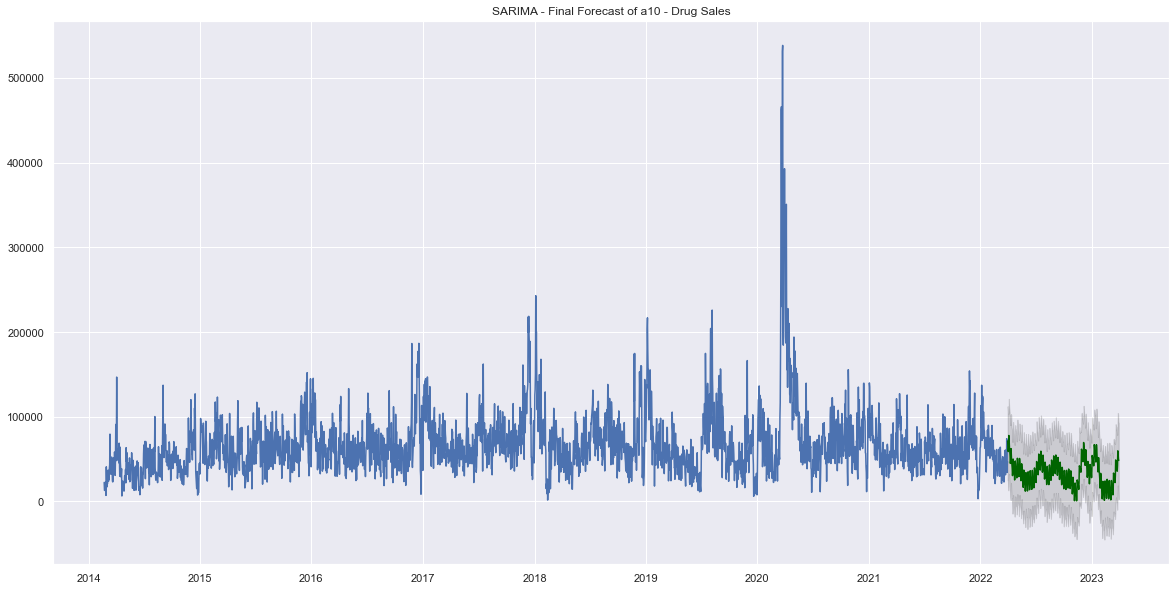

In [37]:
# Plot
plt.plot(df_fb.set_index('ds')['y'])
plt.plot(forecast.set_index('ds')['yhat'], color='darkgreen')
plt.fill_between(forecast.set_index('ds').index, 
                 forecast.set_index('ds')['yhat_lower'], 
                 forecast.set_index('ds')['yhat_upper'], 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()